# Cisco - Ariel University API Security Detection Challenge 2023
## Label 4 code


### Imports and global settings

In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter


# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

dataset_number = 4
test_type = 'label'

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./datasets/dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Platform,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.Attack_Tag,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests
0,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,de-CH,none,same-origin,no-store,?1,document,['ttauth=AnmLHb1kdzYvpficmoZ6ahuxln7RK43GPlS6Q...,"Sun, 18 Dec 2022 01:42:25 GMT",GET,http://127.0.0.1:5000/orders/get/random/2,,200 OK,application/json,8,200,"[{}, {}]",NaN,NaN,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['cid=9ML55TwNFFw14MA2N-N6B8v_LTjMEyppvz3F-H99...,"Sun, 18 Dec 2022 01:44:11 GMT",GET,http://127.0.0.1:5000/orders/check/exists?val=...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br${jndi:ldaphabbologinbr.rel7....",*/*,keep-alive,NaN,?1,"en-US,en;q=0.9,he;q=0.8",none,same-origin,no-store,?1,document,['ttauth=XSgpzlTZBc47Xm36ObpZplFzV2KbUgC68xBcA...,"Sun, 18 Dec 2022 01:34:30 GMT",GET,http://127.0.0.1:5000/login/user?username=Rich...,,401 UNAUTHORIZED,application/json,26,401,"{""error"": ""Access denied""}",LOG4J,NaN,NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10; ...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,"""Windows""",?1,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['ttauth=kOqLuuI_RaiyuKw-926q36BZ4s3ZH251NQ37i...,"Sun, 18 Dec 2022 01:43:59 GMT",GET,http://127.0.0.1:5000/greet/Warren,,200 OK,text/html; charset=utf-8,22,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?1,de-CH,none,websocket,max-age=0,?1,document,['ttauth=rN-ka7ksV-2K6QtY-_wNmdI1i4zY2kVoDQW6e...,"Sun, 18 Dec 2022 01:23:50 GMT",GET,http://127.0.0.1:5000/states/Bagdon?resource=R...,,404 NOT FOUND,application/json,28,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN,NaN,NaN


### Basic dataset label arrangements

In [2]:
from urllib.parse import urlparse

# Extracts the path up until the endpoint from the url
def url_path_mid(row):
    parsed = urlparse(row["request.url"])
    return parsed.path[:-1]

# Extracts the path endpoint from the url
def url_path_end(row):
    parsed = urlparse(row["request.url"])
    return parsed.path[-1]

# Extracts the queries from the url
def url_query(row):
    parsed = urlparse(row["request.url"])
    return parsed.query

# Extracts the length of the url
def url_len(row):
    return len(row["request.url"])

# Checks if any of the suspected headers contains "${jndi"
def has_jndi(row):
    if "${jndi" in str(row["request.headers.Accept-Encoding"]):
        return True
    elif "${jndi" in str(row["request.headers.Sec-Fetch-Site"]):
        return True
    elif "${jndi" in str(row["request.headers.Sec-Fetch-Dest"]):
        return True
    elif "${jndi" in str(row["request.headers.Set-Cookie"]):
        return True
    return False

# Checks if the url path contains a double dot symbolized by ".."
def has_double_dot(row):
    if ".." in row["url_path_mid"]:
        return True
    elif ".." in row["url_path_end"]:
        return True
    return False

# Checks if the url path contains a double underscore symbolized by "__"
def has_double_underscore(row):
    if "__" in row["url_path_mid"]:
        return True
    if "__" in row["url_path_end"]:
        return True
    return False

# Main SQL keywords to look for in the url query
keywords = ["SELECT", "FROM", "or"]

# Checks if the url query contains any of the main SQL keywords
def has_sql_keywords(row):
    for kw in keywords:
        if kw == "SELECT" and f"{kw}%20" in row["url_query"]:
            return True
        elif f"%20{kw}%20" in row["url_query"]:
            return True
    return False

# Checks if the url contains the word "forum"
def has_forum(row):
    if "forum" in row["url_path_mid"]:
        return True
    if "forum" in row["url_path_end"]:
        return True
    return False

In [3]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# make new columns for the features
df['url_length'] = df.apply(lambda row: url_len(row), axis=1)
df["url_path_mid"] = df.apply(lambda row: url_path_mid(row), axis=1)
df["url_path_end"] = df.apply(lambda row: url_path_end(row), axis=1)
df["url_query"] = df.apply(lambda row: url_query(row), axis=1)
df["has_dollarsign"] = df.apply(lambda row: has_jndi(row), axis=1)
df["has_doubledot"] = df.apply(lambda row: has_double_dot(row), axis=1)
df["has_doubleUnderScore"] = df.apply(lambda row: has_double_underscore(row), axis=1)
df["has_sql_keyword"] = df.apply(lambda row: has_sql_keywords(row), axis=1)
df["has_forum"] = df.apply(lambda row: has_forum(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)
df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Platform,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,attack_type,label,url_length,url_path_mid,url_path_end,url_query,has_dollarsign,has_doubledot,has_doubleUnderScore,has_sql_keyword,has_forum
0,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,de-CH,none,same-origin,no-store,?1,document,['ttauth=AnmLHb1kdzYvpficmoZ6ahuxln7RK43GPlS6Q...,"Sun, 18 Dec 2022 01:42:25 GMT",GET,http://127.0.0.1:5000/orders/get/random/2,,200 OK,application/json,8,200,"[{}, {}]",NaN,NaN,NaN,NaN,NaN,Benign,Benign,41,/orders/get/random/,2,,False,False,False,False,False
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['cid=9ML55TwNFFw14MA2N-N6B8v_LTjMEyppvz3F-H99...,"Sun, 18 Dec 2022 01:44:11 GMT",GET,http://127.0.0.1:5000/orders/check/exists?val=...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN,NaN,Benign,Benign,50,/orders/check/exist,s,val=8215,False,False,False,False,False
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br${jndi:ldaphabbologinbr.rel7....",*/*,keep-alive,NaN,?1,"en-US,en;q=0.9,he;q=0.8",none,same-origin,no-store,?1,document,['ttauth=XSgpzlTZBc47Xm36ObpZplFzV2KbUgC68xBcA...,"Sun, 18 Dec 2022 01:34:30 GMT",GET,http://127.0.0.1:5000/login/user?username=Rich...,,401 UNAUTHORIZED,application/json,26,401,"{""error"": ""Access denied""}",NaN,NaN,NaN,NaN,NaN,LOG4J,Malware,79,/login/use,r,username=Richard&password=Uq3T8e7o4QxiCA21JlRN,True,False,False,False,False
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10; ...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,"""Windows""",?1,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['ttauth=kOqLuuI_RaiyuKw-926q36BZ4s3ZH251NQ37i...,"Sun, 18 Dec 2022 01:43:59 GMT",GET,http://127.0.0.1:5000/greet/Warren,,200 OK,text/html; charset=utf-8,22,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,NaN,Benign,Benign,34,/greet/Warre,n,,False,False,False,False,False
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?1,de-CH,none,websocket,max-age=0,?1,document,['ttauth=rN-ka7ksV-2K6QtY-_wNmdI1i4zY2kVoDQW6e...,"Sun, 18 Dec 2022 01:23:50 GMT",GET,http://127.0.0.1:5000/states/Bagdon?resource=R...,,404 NOT FOUND,application/json,28,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN,NaN,Benign,Benign,97,/states/Bagdo,n,resource=RX372IP5FlyRSI_mXxMOmShXhEptFFONbczaY...,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182762,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,NaN,?0,"en-US,en;q=0.5",none,websocket,no-cache,?1,document,['ttauth=NPpRHbzfv7BJ5RGB9-oJNl30Ttdc8RYxbuiSe...,"Sun, 18 Dec 2022 01:25:40 GMT",GET,http://127.0.0.1:5000/login/user?username=Brue...,,401 UNAUTHORIZED,application/json,26,401,"{""error"": ""Access denied""}",NaN,NaN,NaN,NaN,NaN,SQL Injection,Malware,145,/login/use,r,username=Brueggeman&password=JonaBarkerOJPwjin...,False,False,False,True,False
182763,127.0.0.1:500

In [4]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    df[column] = df[column].fillna('None')
    
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Platform,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,attack_type,label,url_length,url_path_mid,url_path_end,url_query,has_dollarsign,has_doubledot,has_doubleUnderScore,has_sql_keyword,has_forum
0,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,de-CH,none,same-origin,no-store,?1,document,['ttauth=AnmLHb1kdzYvpficmoZ6ahuxln7RK43GPlS6Q...,"Sun, 18 Dec 2022 01:42:25 GMT",GET,http://127.0.0.1:5000/orders/get/random/2,,200 OK,application/json,8,200,"[{}, {}]",None,None,None,None,None,Benign,Benign,41,/orders/get/random/,2,,False,False,False,False,False
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?0,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['cid=9ML55TwNFFw14MA2N-N6B8v_LTjMEyppvz3F-H99...,"Sun, 18 Dec 2022 01:44:11 GMT",GET,http://127.0.0.1:5000/orders/check/exists?val=...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",None,None,None,None,None,Benign,Benign,50,/orders/check/exist,s,val=8215,False,False,False,False,False
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br${jndi:ldaphabbologinbr.rel7....",*/*,keep-alive,None,?1,"en-US,en;q=0.9,he;q=0.8",none,same-origin,no-store,?1,document,['ttauth=XSgpzlTZBc47Xm36ObpZplFzV2KbUgC68xBcA...,"Sun, 18 Dec 2022 01:34:30 GMT",GET,http://127.0.0.1:5000/login/user?username=Rich...,,401 UNAUTHORIZED,application/json,26,401,"{""error"": ""Access denied""}",None,None,None,None,None,LOG4J,Malware,79,/login/use,r,username=Richard&password=Uq3T8e7o4QxiCA21JlRN,True,False,False,False,False
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10; ...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,"""Windows""",?1,"en-US,en;q=0.9,he;q=0.8",none,websocket,no-cache,?1,document,['ttauth=kOqLuuI_RaiyuKw-926q36BZ4s3ZH251NQ37i...,"Sun, 18 Dec 2022 01:43:59 GMT",GET,http://127.0.0.1:5000/greet/Warren,,200 OK,text/html; charset=utf-8,22,200,text/html; charset=utf-8,None,None,None,None,None,Benign,Benign,34,/greet/Warre,n,,False,False,False,False,False
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,"""Windows""",?1,de-CH,none,websocket,max-age=0,?1,document,['ttauth=rN-ka7ksV-2K6QtY-_wNmdI1i4zY2kVoDQW6e...,"Sun, 18 Dec 2022 01:23:50 GMT",GET,http://127.0.0.1:5000/states/Bagdon?resource=R...,,404 NOT FOUND,application/json,28,404,"{""error"": ""State not found""}",None,None,None,None,None,Benign,Benign,97,/states/Bagdo,n,resource=RX372IP5FlyRSI_mXxMOmShXhEptFFONbczaY...,False,False,False,False,False


In [5]:
# This is a list of the headers that we want to remove from our model
COLUMNS_TO_REMOVE = ['request.body',
                    'response.headers.Content-Length',
                    'request.headers.Date', 
                    "request.headers.Sec-Fetch-Dest", 
                    "request.headers.Connection", 
                    "request.headers.Accept", 
                    "request.headers.Sec-Fetch-User",
                    "request.headers.Host",
                    "response.headers.Set-Cookie", 
                    "response.status",
                    "request.url"]

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()

    # Run LabelEncoder on the chosen features
    for column in df.columns.to_list(): 
        df[column] = le.fit_transform(df[column])
    
    # # Remove some columns that may be needed
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)
df.head()

,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Sec-Ch-Ua-Platform,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Set-Cookie,request.method,response.headers.Content-Type,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,request.headers.Upgrade-Insecure-Requests,attack_type,label,url_length,url_path_mid,url_path_end,url_query,has_dollarsign,has_doubledot,has_doubleUnderScore,has_sql_keyword,has_forum
0,2,1,0,0,2,1,1,3,112176,0,0,0,258,2,0,29,1,0,0,12,10097,5,0,0,0,0,0,0
1,24,1,0,0,4,1,2,2,8413,0,0,5,9586,2,0,29,1,0,0,21,9088,51,62691,0,0,0,0,0
2,11,181,1,1,4,1,1,3,130505,0,0,4,2861,2,0,29,1,3,1,50,9087,50,50438,1,0,0,0,0
3,1,637,0,1,4,1,2,2,141830,0,1,0,260,2,0,29,1,0,0,5,2264,46,0,0,0,0,0,0
4,16,1,0,1,2,1,2,1,147511,0,0,5,9588,2,0,29,1,0,0,68,10222,46,33563,0,0,0,0,0


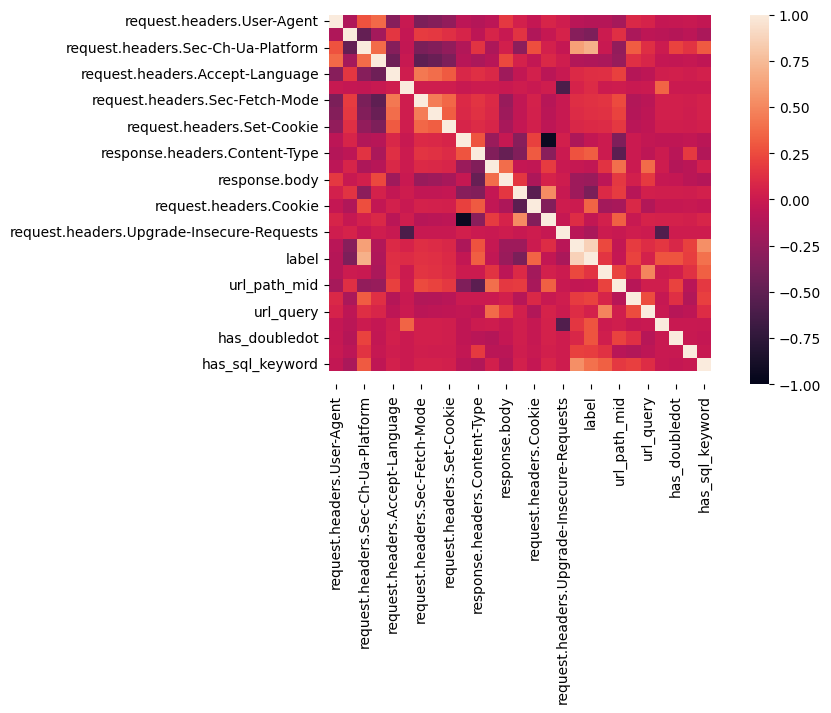

In [6]:
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=False)

In [7]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182767 entries, 0 to 182766
Data columns (total 28 columns):
 #   Column                                     Non-Null Count   Dtype
---  ------                                     --------------   -----
 0   request.headers.User-Agent                 182767 non-null  int64
 1   request.headers.Accept-Encoding            182767 non-null  int64
 2   request.headers.Sec-Ch-Ua-Platform         182767 non-null  int64
 3   request.headers.Sec-Ch-Ua-Mobile           182767 non-null  int64
 4   request.headers.Accept-Language            182767 non-null  int64
 5   request.headers.Sec-Fetch-Site             182767 non-null  int64
 6   request.headers.Sec-Fetch-Mode             182767 non-null  int64
 7   request.headers.Cache-Control              182767 non-null  int64
 8   request.headers.Set-Cookie                 182767 non-null  int64
 9   request.method                             182767 non-null  int64
 10  response.headers.Content-Type   

In [8]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Sec-Ch-Ua-Platform', 'request.headers.Sec-Ch-Ua-Mobile', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Cache-Control', 'request.headers.Set-Cookie', 'request.method', 'response.headers.Content-Type', 'response.status_code', 'response.body', 'response.headers.Location', 'request.headers.Cookie', 'request.headers.Content-Length', 'request.headers.Upgrade-Insecure-Requests', 'url_length', 'url_path_mid', 'url_path_end', 'url_query', 'has_dollarsign', 'has_doubledot', 'has_doubleUnderScore', 'has_sql_keyword', 'has_forum']


request.headers.User-Agent                   int64
request.headers.Accept-Encoding              int64
request.headers.Sec-Ch-Ua-Platform           int64
request.headers.Sec-Ch-Ua-Mobile             int64
request.headers.Accept-Language              int64
request.headers.Sec-Fetch-Site               int64
request.headers.Sec-Fetch-Mode               int64
request.headers.Cache-Control                int64
request.headers.Set-Cookie                   int64
request.method                               int64
response.headers.Content-Type                int64
response.status_code                         int64
response.body                                int64
response.headers.Location                    int64
request.headers.Cookie                       int64
request.headers.Content-Length               int64
request.headers.Upgrade-Insecure-Requests    int64
attack_type                                  int64
label                                        int64
url_length                     

## Train test split

In [9]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing RandomForest model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(150508, 26) (150508,)
(32259, 26) (32259,)


Counter({0: 143297, 1: 39470})

## Model choosing and fitting

In [10]:
# We train the model on the train dataset
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))


[(0, 118005), (1, 32503)]


## Result printout

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000     25292
           1    1.00000   1.00000   1.00000      6967

    accuracy                        1.00000     32259
   macro avg    1.00000   1.00000   1.00000     32259
weighted avg    1.00000   1.00000   1.00000     32259



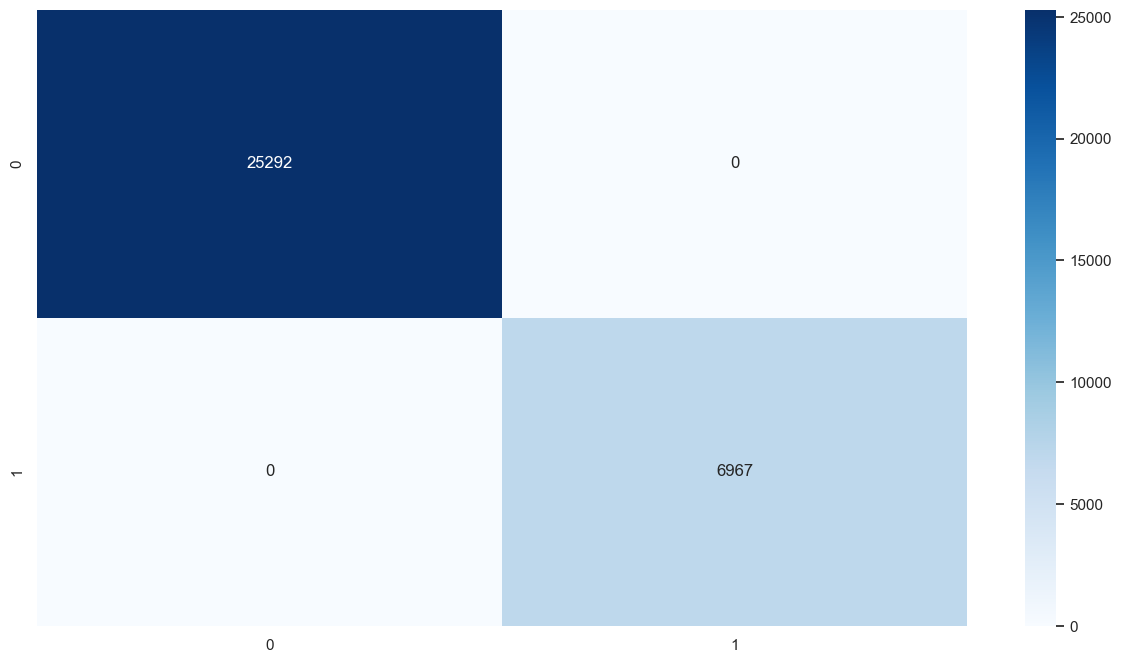

In [11]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})

predictions = clf.predict(X_test)

true_labels = y_test
clf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(clf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

# Test

In [12]:
# Now it's your turn, use the model you have just created :)

# Read the valuation json, preprocess it and run your model 
with open(f'./datasets/dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)

# Preprocess the validation dataset, remember that here you don't have the labels
test_df['url_length'] = test_df.apply(lambda row: url_len(row), axis=1)
test_df["url_path_mid"] = test_df.apply(lambda row: url_path_mid(row), axis=1)
test_df["url_path_end"] = test_df.apply(lambda row: url_path_end(row), axis=1)
test_df["url_query"] = test_df.apply(lambda row: url_query(row), axis=1)
test_df["has_dollarsign"] = test_df.apply(lambda row: has_jndi(row), axis=1)
test_df["has_doubledot"] = test_df.apply(lambda row: has_double_dot(row), axis=1)
test_df["has_doubleUnderScore"] = test_df.apply(lambda row: has_double_underscore(row), axis=1)
test_df["has_sql_keyword"] = test_df.apply(lambda row: has_sql_keywords(row), axis=1)
test_df["has_forum"] = test_df.apply(lambda row: has_forum(row), axis=1)
for column in test_df.columns[test_df.isna().any()].tolist():
    test_df[column] = test_df[column].fillna('None')
test_df = vectorize_df(test_df)

# Predict with your model
X = test_df[features_list].to_numpy()
predictions = clf.predict(X)

# Save your predictions

In [13]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'./datasets/dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')